# Exploratory Data Analysis of MIMIC-IV to uncover Sepsis-3 drift 
This notebook contains various plots and analyses of changes over the years in components of the Sepsis-3 label.

Many cells in this notebook reference the final output of the main training/evaluation script. These can be found in the `cache` directory after the main script has run to completion.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
from scipy.stats import pearsonr
import seaborn as sns
from tqdm import tqdm

from os.path import dirname, realpath
import sys
sys.path.append(realpath('.'))

In [117]:
pd.set_option('display.max_rows', 50)

## Functions

In [118]:
def assign_splits(meta, split_group, test_years, train_years='2008-2010', split_probs=[0.6, 0.2, 0.2]):
    # assign train_years as a list of years [2008, 2010] inclusive for instance. 
    train_start, train_end = map(int, train_years.split('-'))
    meta['split_group'] = None 

    meta.loc[(meta['intime'].dt.year>=train_start) & (meta['intime'].dt.year<=train_end), 'split_group'] = 'train'

    # dev will be a subset of train, of proportion split_probs[dev]
    dev_prob = split_probs[1]
    train_rows = meta[meta.split_group=='train'].shape[0]
    dev_rows = int(dev_prob*train_rows)
    meta.loc[meta[meta['split_group']=='train'].head(dev_rows).index, 'split_group'] = 'dev'

    # if testing on training years, then final split is test set 
    if train_years == test_years:
        test_prob = split_probs[2]
        test_rows = int(test_prob*train_rows)
        meta.loc[meta[meta['split_group']=='train'].tail(test_rows).index, 'split_group'] = 'test'

    else:
        test_start, test_end = map(int, test_years.split('-'))
        meta.loc[(meta['intime'].dt.year>=test_start) & (meta['intime'].dt.year<=test_end), 'split_group'] = 'test'
        
def flatten_timeseries(aggregated_df):
    if 'charttime' in aggregated_df.columns:
        aggregated_df = aggregated_df.drop(columns='charttime')
    return pd.pivot(aggregated_df, index='hadm_id', columns='hour')

def anchor_dates(df: pd.DataFrame, columns, patients):
    """Maps dates to approximate real dates using anchor_year_group conversion.

    Note:
        Dates are mapped to the first possible real date, meaning that they may
        occur up to three years in advance of the returned date.

    Parameters:
        - df: a DataFrame containing the dates to anchor (must include a subject_id column)
        - columns: which columns of `df` to transform (these must be of type `datetime`).
        - patients: The `patients` dataframe, which contains `anchor_year` and `anchor_year_group` columns.

    Returns:
        - anchored_df - a transformed `df` where the specified columns have had their dates transformed.
    """
    # annotate df with anchor_year and anchor_year_group columns
    merge_df = pd.merge(df, patients[["subject_id", "anchor_year", "anchor_year_group"]],
                        how="left", on="subject_id")

    for column in columns:
        merge_df[column] = merge_df[column] - merge_df.anchor_year + merge_df.anchor_year_group

    return merge_df.drop(columns=["anchor_year", "anchor_year_group"])

In [119]:
def filter_to_year_group(df, start_year, end_year, filter_on='charttime'):
    mask = pd.to_datetime(str(start_year)+"-01-01") <= df[filter_on]
    mask &= df[filter_on] < pd.to_datetime(str(end_year+1)+"-01-01")
    return df.loc[mask]

In [120]:
YEAR_GROUPS = ['2008-2010', '2011-2013', '2014-2016', '2017-2019']

## Load Data

data overview:
- [microbio](https://mimic.mit.edu/docs/iv/modules/hosp/microbiologyevents/)
- [prescriptions](https://mimic.mit.edu/docs/iv/modules/hosp/prescriptions/)
- [patients](https://mimic.mit.edu/docs/iv/modules/core/patients/)

In [121]:
%%time
microbio = pd.read_parquet('/storage/stat_cache/microbiologyevents.parquet')
prescriptions = pd.read_parquet('/storage/stat_cache/prescriptions.parquet')
patients = pd.read_parquet('/storage/stat_cache/patients.parquet')
admissions = pd.read_parquet('/storage/stat_cache/admissions.parquet')
icustays = pd.read_parquet('/storage/stat_cache/icustays.parquet')

CPU times: user 15.6 s, sys: 4.28 s, total: 19.9 s
Wall time: 6.68 s


In [122]:
%%time
microbio = anchor_dates(microbio, ['charttime', 'storetime'], patients)
prescriptions = anchor_dates(prescriptions, ['starttime', 'stoptime'], patients)
icustays = anchor_dates(icustays, ['intime', 'outtime'], patients)
admissions = anchor_dates(admissions, ['admittime', 'dischtime', 'deathtime'], patients)
#patients = anchor_dates(patients, ['dod'], patients)

CPU times: user 11.7 s, sys: 5.29 s, total: 17 s
Wall time: 16.6 s


In [123]:
%%time
from sandstone.datasets.stat_collab.mimic_iv import filter_antibiotics
antibiotics = filter_antibiotics(prescriptions)

CPU times: user 27.7 s, sys: 2.61 s, total: 30.3 s
Wall time: 30.2 s


In [124]:
# outputs from main training code
static = pd.read_parquet('final_static_sepsis_analysis.parquet')
aggregated_df = pd.read_parquet('final_hourly_sepsis_analysis.parquet')
ef_agg = aggregated_df.loc[aggregated_df['sepsis3_onset_hour'] > 6]
ef_stat = static.loc[static.hadm_id.isin(ef_agg.hadm_id.unique())]

## total

In [9]:
for year_group in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    microbio_yr = filter_to_year_group(microbio, start_year, end_year)
    prescriptions_yr = filter_to_year_group(prescriptions, start_year, end_year, filter_on='starttime')
    antibio_yr = filter_to_year_group(antibiotics, start_year, end_year, filter_on='starttime')
    
    print("Total microbio:", len(microbio_yr))
    print("Total antibiotics:", len(antibio_yr))
    print("Total prescriptions:", len(prescriptions_yr))
    print()

# 2008-2010
Total microbio: 833833
Total antibiotics: 186162
Total prescriptions: 4112255

# 2011-2013
Total microbio: 769371
Total antibiotics: 182042
Total prescriptions: 4130077

# 2014-2016
Total microbio: 804044
Total antibiotics: 191337
Total prescriptions: 4647045

# 2017-2019
Total microbio: 643830
Total antibiotics: 162043
Total prescriptions: 4030315



### no of each individual antibiotics over the years

In [116]:
counts = antibiotics.groupby('drug').count().iloc[:,0]
counts.loc[counts > 10000].to_dict().keys()

dict_keys(['amoxicillin-clavulanic acid', 'ampicillin sodium', 'ampicillin-sulbactam', 'azithromycin', 'cefazolin', 'cefepime', 'ciprofloxacin hcl', 'ciprofloxacin iv', 'clindamycin', 'gentamicin', 'levofloxacin', 'metronidazole', 'metronidazole (flagyl)', 'piperacillin-tazobactam', 'sulfameth/trimethoprim ds', 'sulfameth/trimethoprim ss', 'vancomycin', 'vancomycin oral liquid'])

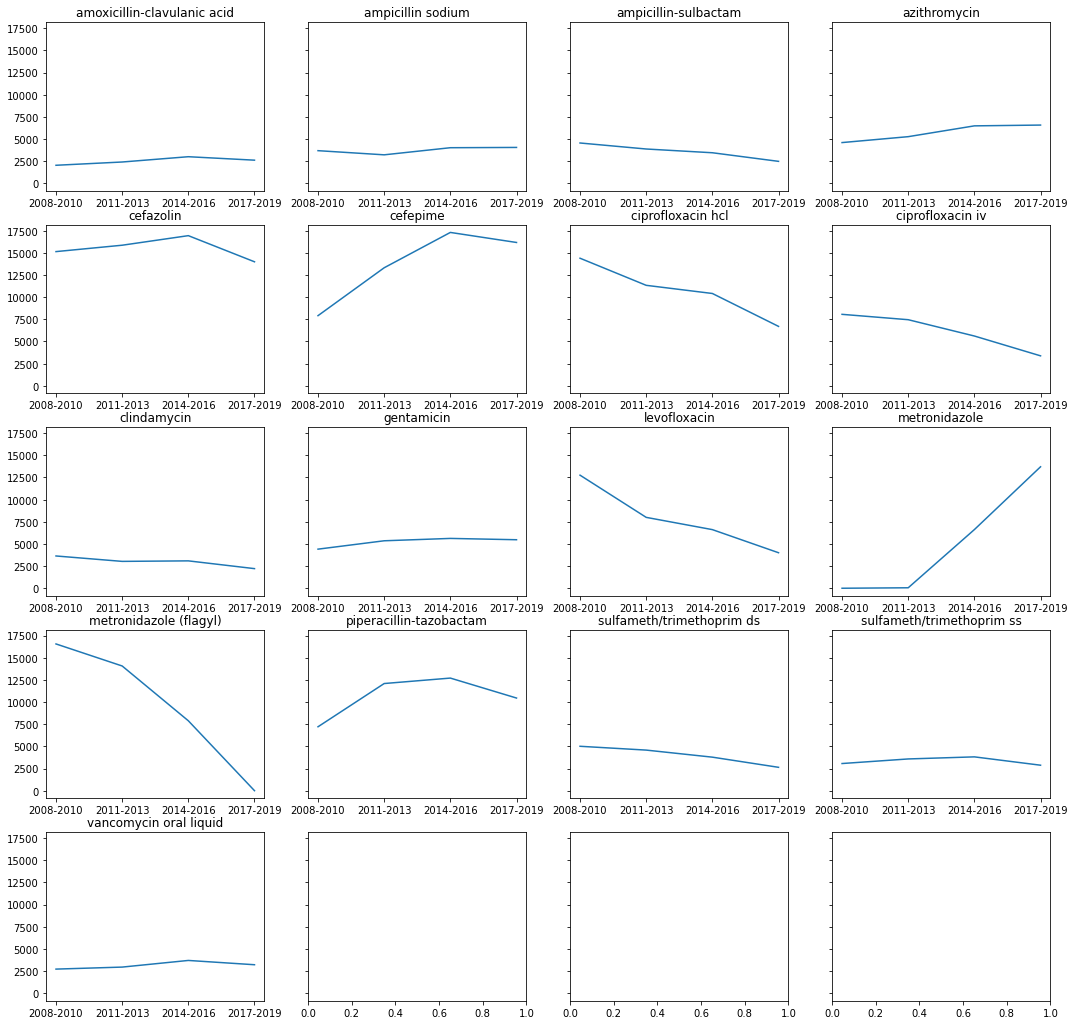

In [109]:
antibio_drugs = ['amoxicillin-clavulanic acid', 'ampicillin sodium', 'ampicillin-sulbactam', 'azithromycin', 'cefazolin', 'cefepime', 'ciprofloxacin hcl', 'ciprofloxacin iv', 'clindamycin', 'gentamicin', 'levofloxacin', 'metronidazole', 'metronidazole (flagyl)', 'piperacillin-tazobactam', 'sulfameth/trimethoprim ds', 'sulfameth/trimethoprim ss', 'vancomycin', 'vancomycin oral liquid']
antibio_drugs.remove('vancomycin')

N_TALL, N_WIDE = 5, 4
assert N_TALL*N_WIDE >= len(antibio_drugs)
fig, axs = plt.subplots(N_TALL, N_WIDE, sharey=True, figsize=(18, 18))

for i, drug in enumerate(antibio_drugs):
    drug_df = antibiotics.loc[antibiotics.drug == drug]
    
    drug_counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(drug_df, start_year, end_year, filter_on='starttime'))
        drug_counts.append(count)
    
    y_i = int(i / N_WIDE)
    x_i = i % N_WIDE
    axs[y_i][x_i].plot(YEAR_GROUPS, drug_counts)
    axs[y_i][x_i].set_title(drug)

#plt.legend(bbox_to_anchor=(1.05, 1.00))


## length of stay distribution

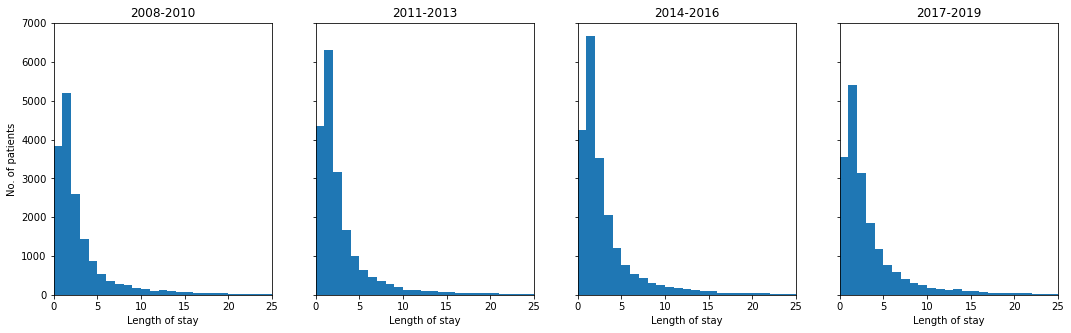

In [162]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 5))

for group_i, year_group in enumerate(YEAR_GROUPS):
    start_year, end_year = map(int, year_group.split('-'))
    icu_yr = filter_to_year_group(icustays, start_year, end_year, filter_on='intime')
    
    axs[group_i].hist(icu_yr.los, bins=range(300))
            
    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 25)
    
    axs[group_i].set_xlabel('Length of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of patients')

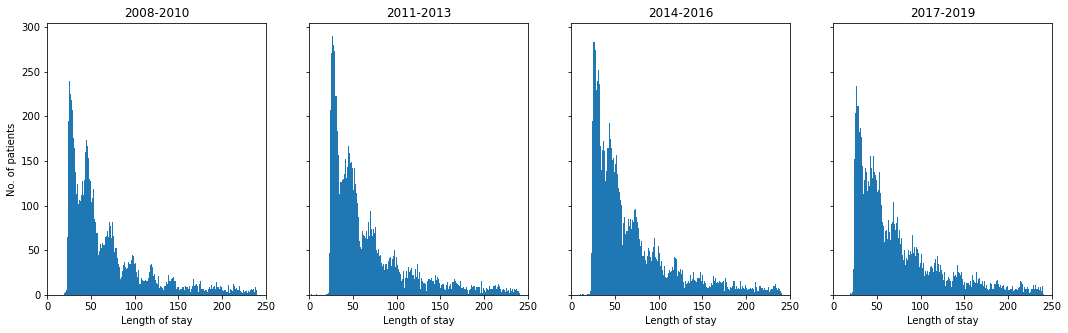

In [144]:
from collections import Counter

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 5))

for group_i, year_group in enumerate(YEAR_GROUPS):
    start_year, end_year = map(int, year_group.split('-'))
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    
    n_patients = agg_yr.subject_id.nunique()
    
    hour_stats = Counter(agg_yr.groupby('subject_id')['hour'].max())
    for key in hour_stats:
        hour_stats[key] = hour_stats[key] / 100 * 100
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)
        
    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 250)
    
    axs[group_i].set_xlabel('Length of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of patients')

### no of each type of microbiological sample over the years

In [11]:
spec_type_counts.keys()

dict_keys(['URINE', 'BLOOD CULTURE', 'SWAB', 'SPUTUM', 'STOOL', 'SEROLOGY/BLOOD', 'TISSUE', 'MRSA SCREEN', 'ABSCESS', 'BRONCHOALVEOLAR LAVAGE', 'PERITONEAL FLUID', 'IMMUNOLOGY', 'CSF;SPINAL FLUID', 'PLEURAL FLUID', 'Staph aureus Screen', 'FLUID,OTHER', 'Blood (EBV)', 'JOINT FLUID', 'Rapid Respiratory Viral Screen & Culture', 'BLOOD CULTURE - NEONATE', 'BRONCHIAL WASHINGS', 'Blood (CMV AB)', 'Immunology (CMV)', 'CATHETER OR LINE', 'BILE', 'BONE MARROW - CYTOGENETICS', 'THROAT FOR STREP', 'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)', 'ANORECTAL/VAGINAL CULTURE', 'Mini-BAL', 'Influenza A/B by DFA', 'FLUID RECEIVED IN BLOOD CULTURE BOTTLES', 'Blood (Toxo)', 'STOOL (RECEIVED IN TRANSPORT SYSTEM)', 'Blood (LYME)', 'FOREIGN BODY', 'FOOT CULTURE', 'Stem Cell - Blood Culture', 'EYE', 'ASPIRATE', 'URINE,KIDNEY', 'AMNIOTIC FLUID', 'SKIN SCRAPINGS', 'EAR', 'DIALYSIS FLUID', 'THROAT CULTURE', 'NEOPLASTIC BLOOD', 'BIOPSY', 'BRONCHIAL BRUSH', 'Direct Antigen Test for Herpes Simplex Virus Types 1 & 2', 'VIR

In [143]:
spec_type_counts = microbio.groupby('spec_type_desc')['subject_id'].count().to_dict()
spec_type_counts = {k: v for k, v in sorted(spec_type_counts.items(), key=lambda item: item[1], reverse=True)}

In [209]:
# most percent-wise change
spec_types = list(spec_type_counts.keys())

result = []
for i, spec_type in enumerate(tqdm(spec_type_counts.keys())):
    spec_df = microbio.loc[microbio.spec_type_desc == spec_type]
    
    spec_counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(spec_df, start_year, end_year, filter_on='charttime'))
        spec_counts.append(count)
        
        change = (count - spec_counts[0])
        
        if spec_counts[0] != 0:
            percent_change = (count / spec_counts[0])*100 - 100
        else:
            percent_change = np.nan
        
        result.append([spec_type, year_group, count, change, percent_change])

    
result = pd.DataFrame(result, columns=['spec_type', 'year_group', 'count', 'change', 'percent_change'])
df = result.loc[result.year_group=='2017-2019'].dropna()
#most_change = df.iloc[df.change.argsort()[::-1]].spec_type.tolist()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:21<00:00,  4.35it/s]


11946.0

In [212]:
means = result.groupby('spec_type').mean()
stds = result.groupby('spec_type').std()

result['z_score'] = np.nan
for i, spec_type in enumerate(tqdm(spec_type_counts.keys())):
    m = means.loc[spec_type]['count']
    s = stds.loc[spec_type]['count']
    result.loc[result.spec_type == spec_type, 'z_score'] = (result.loc[result.spec_type == spec_type, 'count'] - m)/s
    
result

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 837.10it/s]


,spec_type,year_group,count,change,percent_change,z_score
0,URINE,2008-2010,221335,0,0.000000,-0.506512
1,URINE,2011-2013,211626,-9709,-4.386563,-0.938270
2,URINE,2014-2016,263363,42028,18.988411,1.362468
3,URINE,2017-2019,234576,13241,5.982334,0.082314
4,BLOOD CULTURE,2008-2010,171630,0,0.000000,1.049294
...,...,...,...,...,...,...
375,CHLAMYDIA CULTURE,2017-2019,0,0,NaN,-0.500000
376,MICRO PROBLEM PATIENT,2008-2010,0,0,NaN,NaN
377,MICRO PROBLEM PATIENT,2011-2013,0,0,NaN,NaN
378,MICRO PROBLEM PATIENT,2014-2016,0,0,NaN,NaN


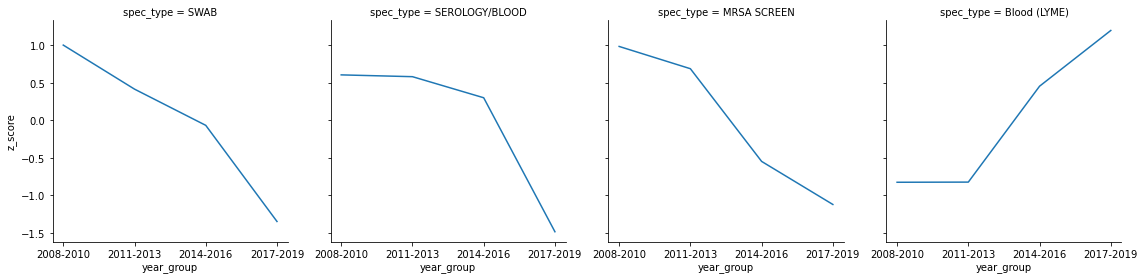

In [213]:
g = sns.FacetGrid(result.loc[result.spec_type.isin(['SWAB', 'MRSA SCREEN', 'SEROLOGY/BLOOD', 'Blood (LYME)'])],
                  col="spec_type", col_wrap=4, height=4)
g.map_dataframe(sns.lineplot, x="year_group", y='z_score')

Table showing those specimen types with largest change

In [224]:
comparison_df = result.pivot(index='spec_type',columns='year_group',values=['count','change','percent_change'])
comparison_df = comparison_df.drop(columns=[
    ('change', '2008-2010'),
    ('change', '2011-2013'),
    ('change', '2014-2016'),
    ('percent_change', '2008-2010'),
    ('percent_change', '2011-2013'),
    ('percent_change', '2014-2016'),
])
comparison_df[[
    ('count', '2008-2010'),
    ('count', '2011-2013'),
    ('count', '2014-2016'),
    ('count', '2017-2019'),
    ('change', '2017-2019'),
]] = comparison_df[[
    ('count', '2008-2010'),
    ('count', '2011-2013'),
    ('count', '2014-2016'),
    ('count', '2017-2019'),
    ('change', '2017-2019'),
]].astype(int)

comparison_df[[
    ('percent_change', '2017-2019'),
]] = comparison_df[[
    ('percent_change', '2017-2019'),
]].round(0)
comparison_df.iloc[comparison_df[('change','2017-2019')].abs().argsort()[::-1]].iloc[:20]

count                                  change  \
year_group                 2008-2010 2011-2013 2014-2016 2017-2019 2017-2019   
spec_type                                                                      
SWAB                           92304     79169     68363     39677    -52627   
MRSA SCREEN                    39086     34375     14766      5657    -33429   
BLOOD CULTURE                 171630    158924    163711    144620    -27010   
SPUTUM                         52437     39027     40078     32135    -20302   
SEROLOGY/BLOOD                 35713     35489     32866     16187    -19526   
STOOL                          47316     38649     38166     28502    -18814   
IMMUNOLOGY                     13524     14336     11085       209    -13315   
URINE                         221335    211626    263363    234576     13241   
BONE MARROW - CYTOGENETICS      7442      3643         5         0     -7442   
TISSUE                         21455     26311     32957     28481      7026   
Immunology (CMV)                5921      5278      4285        42     -5879   
CATHETER OR LINE                6862      3653      2014      1397     -5465   
CSF;SPINAL FLUID               10725      8527      8601      6333     -4392   
BRONCHIAL WASHINGS              2214      2577      5087      6442      4228   
Influenza A/B by DFA            4214      2771       532         0     -4214   
ABSCESS                         9597     11657     12734     13796      4199   
Blood (LYME)                       0         4      2414      3815      3815   
PLEURAL FLUID                   7560      7560      8834      9826      2266   
BRONCHOALVEOLAR LAVAGE         12772     10930     13205     10523     -2249   
Staph aureus Screen             3609      9151     11949      5608      1999   

                           percent_change  
year_group                      2017-2019  
spec_type                                  
SWAB                                -57.0  
MRSA SCREEN                         -86.0  
BLOOD CULTURE                       -16.0  
SPUTUM                              -39.0  
SEROLOGY/BLOOD                      -55.0  
STOOL                               -40.0  
IMMUNOLOGY                          -98.0  
URINE                                 6.0  
BONE MARROW - CYTOGENETICS         -100.0  
TISSUE                               33.0  
Immunology (CMV)                    -99.0  
CATHETER OR LINE                    -80.0  
CSF;SPINAL FLUID                    -41.0  
BRONCHIAL WASHINGS                  191.0  
Influenza A/B by DFA               -100.0  
ABSCESS                              44.0  
Blood (LYME)                          NaN  
PLEURAL FLUID                        30.0  
BRONCHOALVEOLAR LAVAGE              -18.0  
Staph aureus Screen                  55.0

Table showing those specimen types with largest change between 2014-2016 and 2017-2019

In [52]:
comparison_df['changeX'] = comparison_df[('count', '2017-2019')] - comparison_df[('count', '2014-2016')]
comparison_df['changeX%'] = (comparison_df['changeX'] / comparison_df[('count', '2014-2016')])*100
comparison_df['changeX%'].fillna(0, inplace=True)

In [31]:
df.iloc[df.change.abs().argsort()[::-1]].iloc[:25]

,spec_type,year_group,count,change,percent_change
11,SWAB,2017-2019,39677,-52627,-57.014864
31,MRSA SCREEN,2017-2019,5657,-33429,-85.526787
7,BLOOD CULTURE,2017-2019,144620,-27010,-15.737342
15,SPUTUM,2017-2019,32135,-20302,-38.716937
23,SEROLOGY/BLOOD,2017-2019,16187,-19526,-54.674768
19,STOOL,2017-2019,28502,-18814,-39.762448
47,IMMUNOLOGY,2017-2019,209,-13315,-98.454599
3,URINE,2017-2019,234576,13241,5.982334
103,BONE MARROW - CYTOGENETICS,2017-2019,0,-7442,-100.000000
27,TISSUE,2017-2019,28481,7026,32.747611


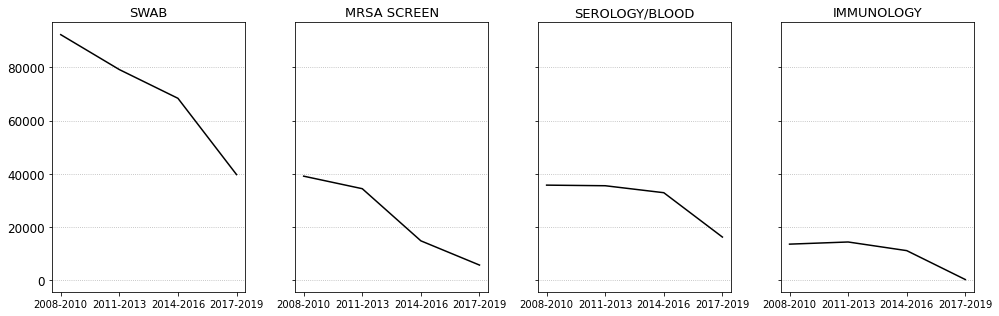

In [253]:
spec_types = ['SWAB', 'MRSA SCREEN', 'SEROLOGY/BLOOD', 'IMMUNOLOGY']

N_TALL, N_WIDE = 1, 4
assert N_TALL*N_WIDE >= len(spec_types)
fig, axs = plt.subplots(N_TALL, N_WIDE, sharey=True, figsize=(14, 4.5))

for i, spec_type in enumerate(spec_types):
    spec_df = microbio.loc[microbio.spec_type_desc == spec_type]
    
    spec_counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(spec_df, start_year, end_year, filter_on='charttime'))
        #if count != 0:
        #    count = np.log(count)
        spec_counts.append(count)
    
    #y_i = int(i / N_WIDE)
    x_i = i % N_WIDE
    axs[x_i].plot(YEAR_GROUPS, spec_counts, color='black')
    axs[x_i].set_title(spec_type, fontsize=13)
    #axs[y_i][x_i].set_yscale('log')
    #axs[y_i][x_i].tick_params(axis='x', which='major', labelsize=8)
    axs[x_i].tick_params(axis='y', which='major', labelsize=12)
    
    axs[x_i].grid(axis='y', which='major', linestyle='dotted')#, dashes=(20,20))
    
    #axs[y_i][x_i].set_ylim(0, YLIM[i])  
plt.tight_layout()

#plt.show()
plt.savefig("select_cultures.png", dpi=240, transparent=True)

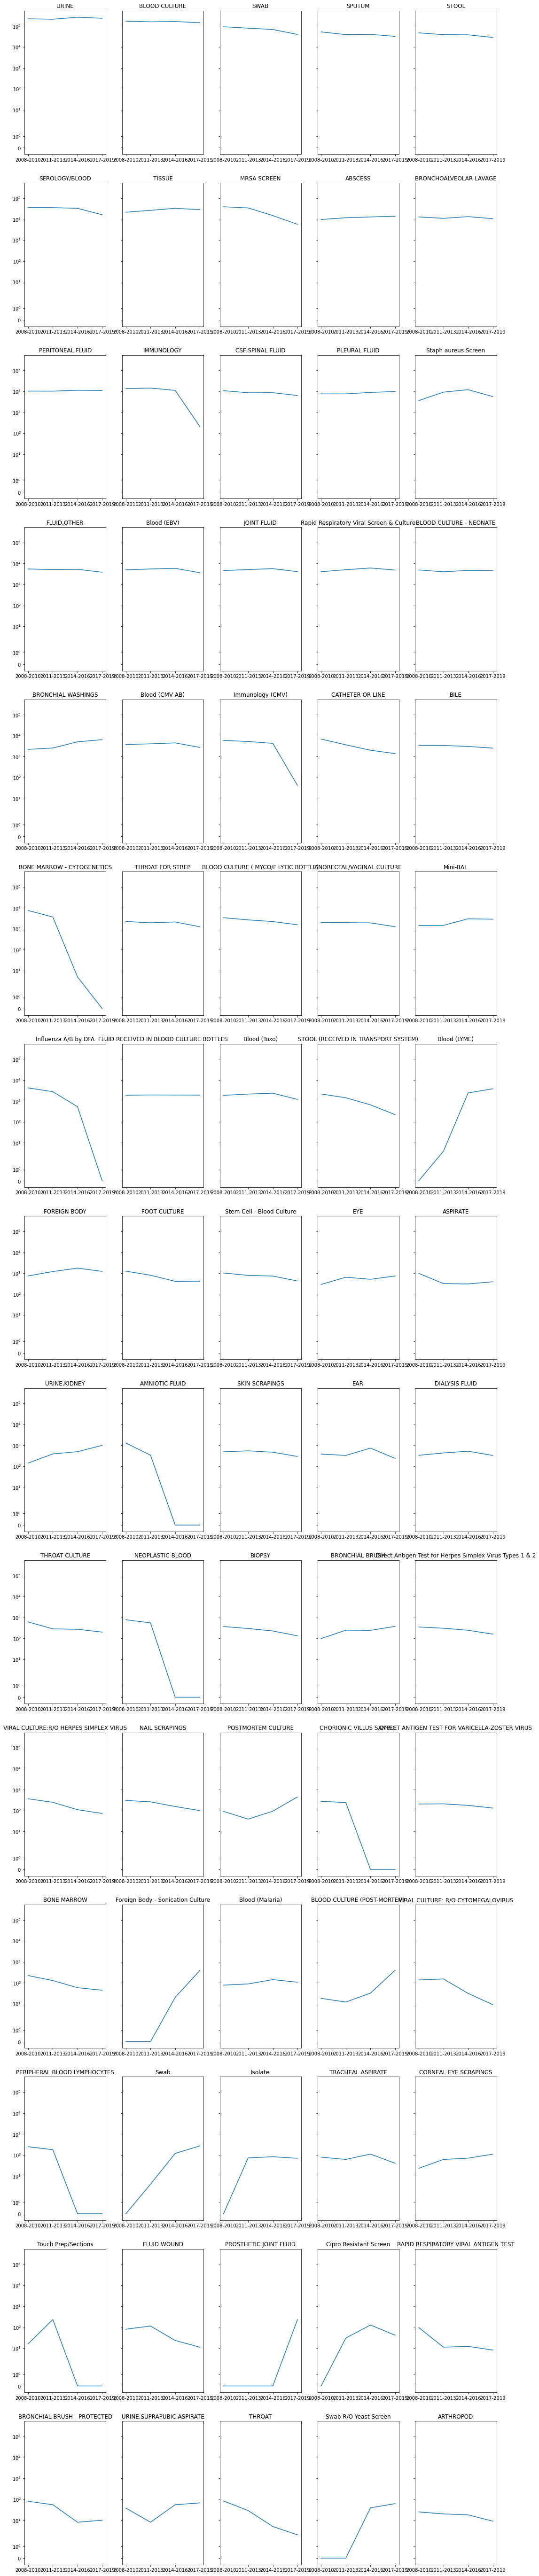

In [74]:
spec_types = list(spec_type_counts.keys())[:75]

N_TALL, N_WIDE = 15, 5
assert N_TALL*N_WIDE >= len(spec_types)
fig, axs = plt.subplots(N_TALL, N_WIDE, sharey=True, figsize=(18, 100))

for i, spec_type in enumerate(spec_types):
    spec_df = microbio.loc[microbio.spec_type_desc == spec_type]
    
    spec_counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(spec_df, start_year, end_year, filter_on='charttime'))
        #if count != 0:
        #    count = np.log(count)
        spec_counts.append(count)
    
    y_i = int(i / N_WIDE)
    x_i = i % N_WIDE
    axs[y_i][x_i].plot(YEAR_GROUPS, spec_counts)
    axs[y_i][x_i].set_title(spec_type)
    #axs[y_i][x_i].set_yscale('log')
    
plt.yscale('symlog')
#plt.savefig('diffs.png', transparent=False, facecolor='white', bbox_inches='tight')
plt.show()

### visualize the events for a few patients

In [71]:
#ef_agg.loc[ef_agg.hadm_id==29992577.0][['antibiotics', 'sepsis3', 'suspicion_of_infection', 'microbio-sample']]

### no of antibiotics/culture/SI/sepsis events per patient over the years

In [70]:
for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(ef_agg, start_year, end_year, filter_on='charttime')
    
    patient_counts = agg_yr.groupby('hadm_id')['microbio-sample'].sum()
    print("avg. no of microbio samples per patient:", patient_counts.mean())
    
    patient_counts = agg_yr.groupby('hadm_id')['suspicion_of_infection'].sum()
    print("avg. no of SI events per patient:", patient_counts.mean())
    
    patient_counts = agg_yr.groupby('hadm_id')['antibiotics'].sum()
    print("avg. no of antibiotics per patient:", patient_counts.mean())
    
    patient_counts = agg_yr.groupby('hadm_id')['sepsis3'].sum()
    print("avg. no of sepsis3 events per patient:", patient_counts.mean())
    
    print()
    
#plt.ylim(0, 375)
#plt.show()

# 2008-2010
avg. no of microbio samples per patient: 88.38564476885645
avg. no of SI events per patient: 3.064476885644769
avg. no of antibiotics per patient: 3.181265206812652
avg. no of sepsis3 events per patient: 2.2798053527980535

# 2011-2013
avg. no of microbio samples per patient: 95.62912087912088
avg. no of SI events per patient: 3.0123626373626373
avg. no of antibiotics per patient: 3.6717032967032965
avg. no of sepsis3 events per patient: 2.1112637362637363

# 2014-2016
avg. no of microbio samples per patient: 90.10028929604628
avg. no of SI events per patient: 2.7878495660559306
avg. no of antibiotics per patient: 3.596914175506268
avg. no of sepsis3 events per patient: 2.0568948891031824

# 2017-2019
avg. no of microbio samples per patient: 84.49865951742628
avg. no of SI events per patient: 3.0482573726541555
avg. no of antibiotics per patient: 4.154602323503128
avg. no of sepsis3 events per patient: 2.462019660411081



## Histogram of no. of cultures/antibiotics during hour of stay

# 2008-2010
Total samples taken in first 10 hrs: 8502
No of patients with samples taken in first 10 hrs: 6429
Total samples taken in remaining hrs: 9823
No of patients with samples taken in remaining hrs: 4001
# 2011-2013
Total samples taken in first 10 hrs: 10838
No of patients with samples taken in first 10 hrs: 8308
Total samples taken in remaining hrs: 9277
No of patients with samples taken in remaining hrs: 3903
# 2014-2016
Total samples taken in first 10 hrs: 9492
No of patients with samples taken in first 10 hrs: 7204
Total samples taken in remaining hrs: 9466
No of patients with samples taken in remaining hrs: 4029
# 2017-2019
Total samples taken in first 10 hrs: 3858
No of patients with samples taken in first 10 hrs: 2569
Total samples taken in remaining hrs: 8308
No of patients with samples taken in remaining hrs: 3400


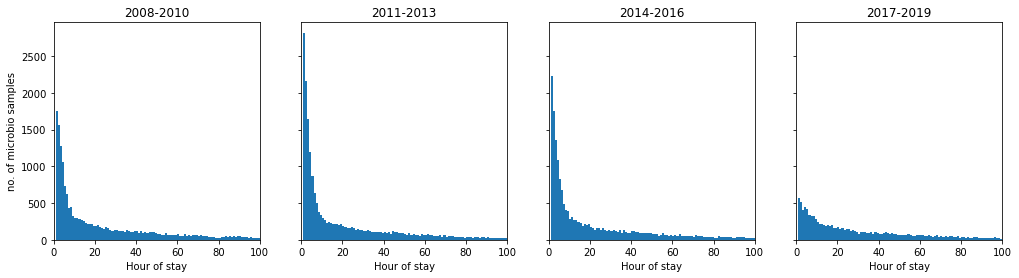

In [34]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    agg_yr = agg_yr.fillna(0)
    
    microbio_hrs = agg_yr.loc[agg_yr['microbio-sample'] == 1]
    hour_stats = microbio_hrs.groupby('hour')['hour'].count().to_dict()
    
    samples_10hrs = microbio_hrs.loc[microbio_hrs.hour <= 10]
    print("Total samples taken in first 10 hrs:", len(samples_10hrs))
    print("No of patients with samples taken in first 10 hrs:", samples_10hrs.subject_id.nunique())
    samples_remaining = microbio_hrs.loc[microbio_hrs.hour > 10]
    print("Total samples taken in remaining hrs:", len(samples_remaining))
    print("No of patients with samples taken in remaining hrs:", samples_remaining.subject_id.nunique())
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 100)
    
    axs[group_i].set_xlabel('Hour of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('no. of microbio samples')
    #print(counts)

# 2008-2010
# 2011-2013
# 2014-2016
# 2017-2019


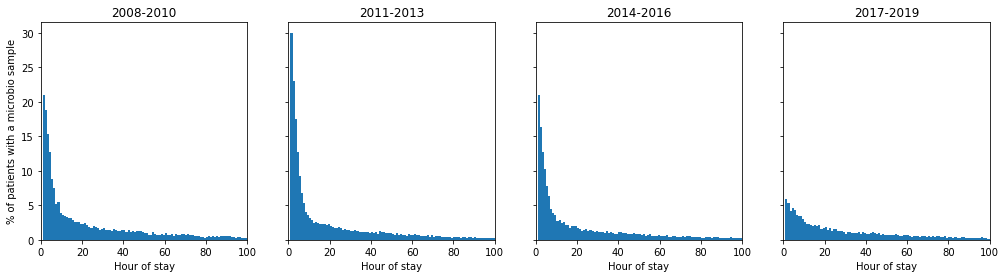

In [35]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    agg_yr = agg_yr.fillna(0)
    
    n_patients = agg_yr.subject_id.nunique()
    
    microbio_hrs = agg_yr.loc[agg_yr['microbio-sample'] == 1]
    hour_stats = microbio_hrs.groupby('hour')['hour'].count().to_dict()
    
    for key in hour_stats:
        hour_stats[key] = hour_stats[key] / n_patients * 100
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 100)
    
    axs[group_i].set_xlabel('Hour of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('% of patients with a microbio sample')
    #print(counts)

# 2008-2010
# 2011-2013
# 2014-2016
# 2017-2019


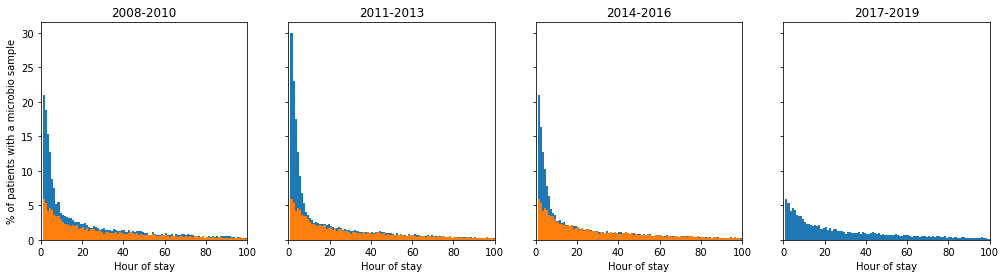

In [42]:
# plotting 2017-2019 on top of the others
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    agg_yr = agg_yr.fillna(0)
    
    n_patients = agg_yr.subject_id.nunique()
    
    microbio_hrs = agg_yr.loc[agg_yr['microbio-sample'] == 1]
    hour_stats = microbio_hrs.groupby('hour')['hour'].count().to_dict()
    
    for key in hour_stats:
        hour_stats[key] = hour_stats[key] / n_patients * 100
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)
    if group_i == 3:
        for group_j in range(3):
            axs[group_j].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)
    
    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 100)
    
    axs[group_i].set_xlabel('Hour of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('% of patients with a microbio sample')
    #print(counts)

# 2008-2010
Total antibiotics in first 10 hrs: 6118
No of patients with antibiotics in first 10 hrs: 4319
Total antibiotics in remaining hrs: 8012
No of patients with antibiotics in remaining hrs: 3328
# 2011-2013
Total antibiotics in first 10 hrs: 7135
No of patients with antibiotics in first 10 hrs: 4807
Total antibiotics in remaining hrs: 9978
No of patients with antibiotics in remaining hrs: 3866
# 2014-2016
Total antibiotics in first 10 hrs: 8005
No of patients with antibiotics in first 10 hrs: 5418
Total antibiotics in remaining hrs: 11107
No of patients with antibiotics in remaining hrs: 4427
# 2017-2019
Total antibiotics in first 10 hrs: 6808
No of patients with antibiotics in first 10 hrs: 4593
Total antibiotics in remaining hrs: 9880
No of patients with antibiotics in remaining hrs: 3788


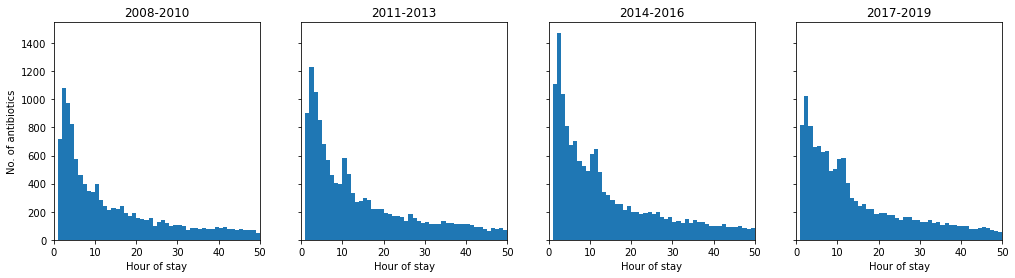

In [36]:
# antibiotics
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    
    antibio_hrs = agg_yr.loc[agg_yr['antibiotics'] == 1]
    hour_stats = antibio_hrs.groupby('hour')['hour'].count().to_dict()
    
    antibio_10hrs = antibio_hrs.loc[antibio_hrs.hour <= 10]
    print("Total antibiotics in first 10 hrs:", len(antibio_10hrs))
    print("No of patients with antibiotics in first 10 hrs:", antibio_10hrs.subject_id.nunique())
    antibio_remaining = antibio_hrs.loc[antibio_hrs.hour > 10]
    print("Total antibiotics in remaining hrs:", len(antibio_remaining))
    print("No of patients with antibiotics in remaining hrs:", antibio_remaining.subject_id.nunique())
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 50)
    
    axs[group_i].set_xlabel('Hour of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of antibiotics')
    #print(counts)

# 2008-2010
# 2011-2013
# 2014-2016
# 2017-2019


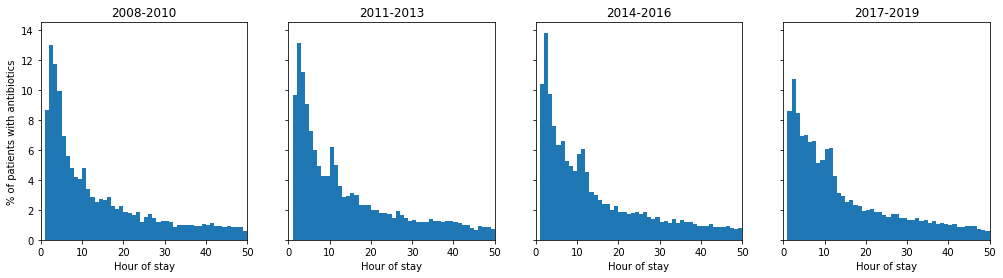

In [46]:
# antibiotics, normalized
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    
    agg_yr = filter_to_year_group(aggregated_df, start_year, end_year, filter_on='charttime')
    
    n_patients = agg_yr.subject_id.nunique()
    
    antibio_hrs = agg_yr.loc[agg_yr['antibiotics'] == 1]
    hour_stats = antibio_hrs.groupby('hour')['hour'].count().to_dict()
    
    for key in hour_stats:
        hour_stats[key] = hour_stats[key] / n_patients * 100
    
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 50)
    
    axs[group_i].set_xlabel('Hour of stay')
    if group_i == 0:
        axs[group_i].set_ylabel('% of patients with antibiotics')
    #print(counts)

### histogram for time-of-day of antibiotics/cultures over the years

In [226]:
from collections import Counter

# 2008-2010
Hour 0-7: 126110
Hour 8-18: 587340
Hour 19-23: 120383

# 2011-2013
Hour 0-7: 112568
Hour 8-18: 548583
Hour 19-23: 108220

# 2014-2016
Hour 0-7: 122879
Hour 8-18: 563685
Hour 19-23: 117480

# 2017-2019
Hour 0-7: 111577
Hour 8-18: 427256
Hour 19-23: 104997



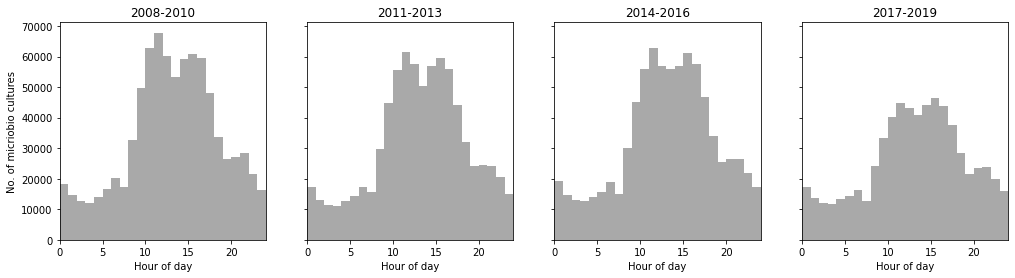

In [241]:
# cultures
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    microbio_yr = filter_to_year_group(microbio, start_year, end_year, filter_on='charttime')
    
    hour_stats = Counter(microbio_yr.charttime.dt.hour)
    
    print("Hour 0-7:", sum([hour_stats[hour] for hour in range(0,8)]))
    print("Hour 8-18:", sum([hour_stats[hour] for hour in range(8,19)]))
    print("Hour 19-23:", sum([hour_stats[hour] for hour in range(19,24)]))
    
    #print(year_group, hour_stats)
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1, color='darkgrey')

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 24)
    
    axs[group_i].set_xlabel('Hour of day')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of micriobio cultures')
    
    print()
    
#plt.ylim(0, 375)
plt.savefig("microbio_day.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

# 2008-2010
Hour 0-7: 15.124131570710203
Hour 8-18: 70.43856503640417
Hour 19-23: 14.437303392885624

# 2011-2013
Hour 0-7: 14.631172737210008
Hour 8-18: 71.30279150110935
Hour 19-23: 14.066035761680645

# 2014-2016
Hour 0-7: 15.282621349080399
Hour 8-18: 70.10623796707642
Hour 19-23: 14.611140683843175

# 2017-2019
Hour 0-7: 17.330195859155367
Hour 8-18: 66.36161719708619
Hour 19-23: 16.308186943758447



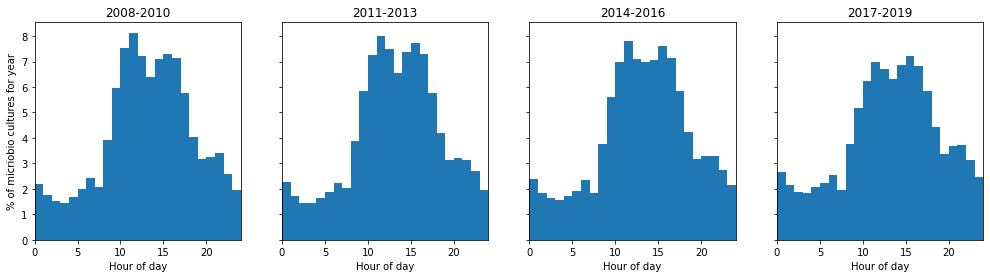

In [48]:
# cultures, normalized
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    microbio_yr = filter_to_year_group(microbio, start_year, end_year, filter_on='charttime')
    
    total_microbio = len(microbio_yr)
    
    hour_stats = Counter(microbio_yr.charttime.dt.hour)
    
    print("Hour 0-7:", sum([hour_stats[hour] for hour in range(0,8)])/total_microbio * 100)
    print("Hour 8-18:", sum([hour_stats[hour] for hour in range(8,19)])/total_microbio * 100)
    print("Hour 19-23:", sum([hour_stats[hour] for hour in range(19,24)])/total_microbio * 100)
    
    #print(year_group, hour_stats)
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], [(x/total_microbio)*100 for x in hour_stats.values()], width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 24)
    
    axs[group_i].set_xlabel('Hour of day')
    if group_i == 0:
        axs[group_i].set_ylabel('% of micriobio cultures for year')
    
    print()
    
#plt.ylim(0, 375)
plt.show()

In [31]:
len(hour_stats.values())

24

# 2008-2010
Hour 0-7: 23660
Hour 8-18: 106609
Hour 19-23: 55893

# 2011-2013
Hour 0-7: 25594
Hour 8-18: 106118
Hour 19-23: 50330

# 2014-2016
Hour 0-7: 31439
Hour 8-18: 112716
Hour 19-23: 47182

# 2017-2019
Hour 0-7: 27506
Hour 8-18: 95660
Hour 19-23: 38877



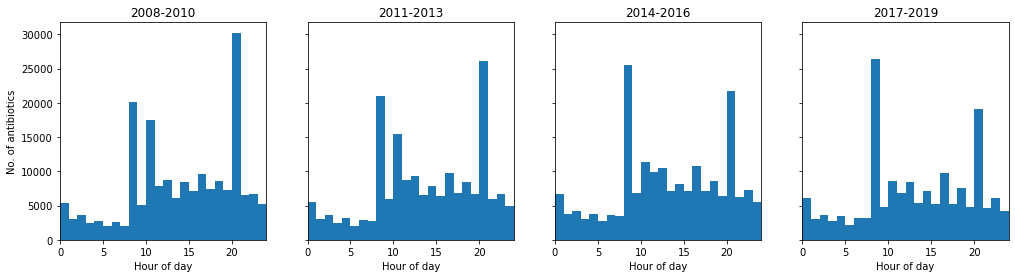

In [149]:
# antibiotics
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    antibio_yr = filter_to_year_group(antibiotics, start_year, end_year, filter_on='starttime')
    
    hour_stats = Counter(antibio_yr.starttime.dt.hour)
    
    print("Hour 0-7:", sum([hour_stats[hour] for hour in range(0,8)]))
    print("Hour 8-18:", sum([hour_stats[hour] for hour in range(8,19)]))
    print("Hour 19-23:", sum([hour_stats[hour] for hour in range(19,24)]))
    
    #print(year_group, hour_stats)
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 24)
    
    axs[group_i].set_xlabel('Hour of day')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of antibiotics')
    
    print()
    
#plt.ylim(0, 375)
plt.show()

# 2008-2010
Hour 0-7: 12.709360664367594
Hour 8-18: 57.266789140640945
Hour 19-23: 30.02385019499146

# 2011-2013
Hour 0-7: 14.059392887355664
Hour 8-18: 58.29314114325266
Hour 19-23: 27.647465969391675

# 2014-2016
Hour 0-7: 16.431218217072498
Hour 8-18: 58.90967246272285
Hour 19-23: 24.659109320204664

# 2017-2019
Hour 0-7: 16.97450676672241
Hour 8-18: 59.03371327363725
Hour 19-23: 23.99177995964034



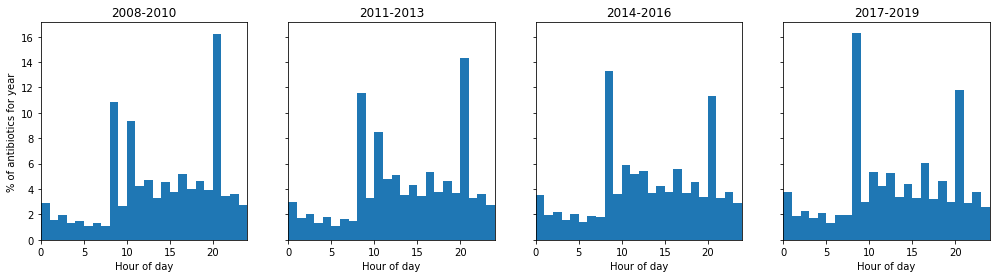

In [150]:
# antibiotics, normalized
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))

for group_i, year_group in enumerate(YEAR_GROUPS):
    print("#", year_group)
    start_year, end_year = map(int, year_group.split('-'))
    antibio_yr = filter_to_year_group(antibiotics, start_year, end_year, filter_on='starttime')
    
    total_antibio = len(antibio_yr)
    
    hour_stats = Counter(antibio_yr.starttime.dt.hour)
    for key in hour_stats:
        hour_stats[key] = hour_stats[key]/total_antibio * 100
    
    print("Hour 0-7:", sum([hour_stats[hour] for hour in range(0,8)]))
    print("Hour 8-18:", sum([hour_stats[hour] for hour in range(8,19)]))
    print("Hour 19-23:", sum([hour_stats[hour] for hour in range(19,24)]))
    
    #print(year_group, hour_stats)
    axs[group_i].bar([x+0.5 for x in hour_stats.keys()], list(hour_stats.values()), width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 24)
    
    axs[group_i].set_xlabel('Hour of day')
    if group_i == 0:
        axs[group_i].set_ylabel('% of antibiotics for year')
    
    print()
    
#plt.ylim(0, 375)
plt.show()

## Sepsis Definition Investigation

In [42]:
for year_group in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    static_df_years = static.copy()

    assign_splits(static_df_years, split_group='test', test_years=year_group)
    aggregated_df_years = aggregated_df.merge(static_df_years[['hadm_id','split_group']], on='hadm_id')
    
    aggregated_df_years = aggregated_df_years.loc[aggregated_df_years.split_group == 'test']
    
    print("Year group:", year_group)
    
    total = aggregated_df_years.shape[0]
    print("SI percentage:", aggregated_df_years.loc[aggregated_df_years['suspicion_of_infection']==True].shape[0]/total)
    print("Antibiotics percentage:", aggregated_df_years.loc[aggregated_df_years['antibiotics']==1].shape[0]/total)
    print("Microbio-sample percentage:", aggregated_df_years.loc[aggregated_df_years['microbio-sample_exist']==1].shape[0]/total)
    print()


Year group: 2008-2010
SI percentage: 0.022900350579943943
Antibiotics percentage: 0.6515469677989167
Microbio-sample percentage: 0.032768860570120496

Year group: 2011-2013
SI percentage: 0.022392138063279002
Antibiotics percentage: 0.6305656759348035
Microbio-sample percentage: 0.032131671460530524

Year group: 2014-2016
SI percentage: 0.01858688525482152
Antibiotics percentage: 0.6259498164980372
Microbio-sample percentage: 0.02579093562876288

Year group: 2017-2019
SI percentage: 0.013142345103437529
Antibiotics percentage: 0.5639837986110209
Microbio-sample percentage: 0.0175519857090705



In [16]:
for year_group in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    year_data = microbio.loc[(microbio['charttime'].dt.year>=start) & (microbio['charttime'].dt.year<=end)]
    count = year_data.shape[0]
    print("Microbio sample count:", count)
    print("Test type:",  year_data.spec_type_desc.value_counts())
    print("Percentage test:", year_data.spec_type_desc.value_counts()/count)
    print()
    

Year group: 2008-2010
Microbio sample count: 833833
Test type: URINE                        221335
BLOOD CULTURE                171630
SWAB                          92304
SPUTUM                        52437
STOOL                         47316
                              ...  
BLOOD                             4
URINE,PROSTATIC MASSAGE           2
SWAB - R/O YEAST                  1
POST-MORTEM VIRAL CULTURE         1
FECAL SWAB                        1
Name: spec_type_desc, Length: 83, dtype: int64
Percentage test: URINE                        0.265443
BLOOD CULTURE                0.205833
SWAB                         0.110698
SPUTUM                       0.062887
STOOL                        0.056745
                               ...   
BLOOD                        0.000005
URINE,PROSTATIC MASSAGE      0.000002
SWAB - R/O YEAST             0.000001
POST-MORTEM VIRAL CULTURE    0.000001
FECAL SWAB                   0.000001
Name: spec_type_desc, Length: 83, dtype: float64

Year grou

In [18]:
admissions = pd.read_parquet('/storage/stat_cache/admissions.parquet')
icustays = pd.read_parquet('/storage/stat_cache/icustays.parquet')

In [19]:
icustays = anchor_dates(icustays, ['intime', 'outtime'], patients)

In [20]:
for year_group in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    count = icustays.loc[(icustays['intime'].dt.year>=start) & (icustays['intime'].dt.year<=end)].shape[0]
    print("Icustays count:", count)

Year group: 2008-2010
Icustays count: 16647
Year group: 2011-2013
Icustays count: 19439
Year group: 2014-2016
Icustays count: 21361
Year group: 2017-2019
Icustays count: 18840


## Onset-hour investigation

In [91]:
onset_hours = aggregated_df.loc[aggregated_df.sepsis3_onset, ['hadm_id','hour']]
onset_hours.rename(columns={'hour': 'sepsis3_onset_hour'}, inplace=True)
aggregated_df = aggregated_df.merge(onset_hours, on='hadm_id', how='left')

2619751


In [114]:
bins=[1,7,13,26,41,999]
#bins=[1,11,200]

Year group: 2008-2010
Average sepsis onset time: 8.926949941792783
1-6: 2423 (71%)
7-12: 457 (13%)
13-25: 311 (9%)
26-40: 112 (3%)
41-999: 133 (4%)

Year group: 2011-2013
Average sepsis onset time: 8.528638730473594
1-6: 2890 (72%)
7-12: 537 (13%)
13-25: 353 (9%)
26-40: 97 (2%)
41-999: 156 (4%)

Year group: 2014-2016
Average sepsis onset time: 8.987229862475441
1-6: 2915 (72%)
7-12: 521 (13%)
13-25: 343 (8%)
26-40: 128 (3%)
41-999: 165 (4%)

Year group: 2017-2019
Average sepsis onset time: 11.778513961192617
1-6: 1359 (64%)
7-12: 283 (13%)
13-25: 217 (10%)
26-40: 102 (5%)
41-999: 152 (7%)



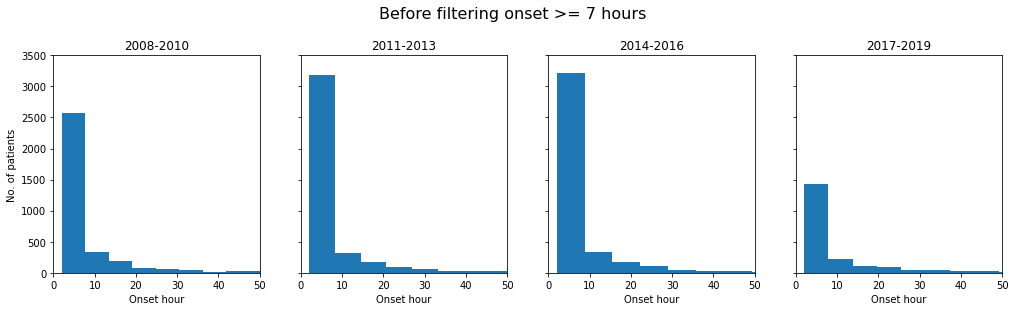

In [115]:
# Unfiltered for onset
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))
for group_i, year_group in enumerate(['2008-2010', '2011-2013', '2014-2016', '2017-2019']):
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    year_data = aggregated_df.loc[(aggregated_df['charttime'].dt.year>=start) & (aggregated_df['charttime'].dt.year<=end)]
    static_data = static.loc[(static['intime'].dt.year>=start) & (static['intime'].dt.year<=end)]
    #print("Sepsis onset hour stats:")
    onset_hours = year_data.groupby('hadm_id')['sepsis3_onset_hour'].first()
    
    axs[group_i].hist(onset_hours, bins=30)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 50)
    
    axs[group_i].set_xlabel('Onset hour')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of patients')
    
    print("Average sepsis onset time:", onset_hours.mean())
    
    hist, _ = np.histogram(onset_hours.dropna(), bins=bins)
    for b_i, b in enumerate(bins[:-1]):
        b_next = bins[b_i+1]
        if b_i != len(bins)-2:
            b_next-=1
        print(f"{b}-{b_next}: {hist[b_i]} ({round((hist[b_i] / np.sum(hist))*100)}%)")
        
    print()
    
plt.ylim(0, 3500)
plt.suptitle("Before filtering onset >= 7 hours", y=1.05, fontsize=16)
plt.show()


In [96]:
sepsis_hadm_ids = aggregated_df.loc[~aggregated_df.sepsis3_onset_hour.isna()].hadm_id.unique()
static['y'] = static.hadm_id.isin(sepsis_hadm_ids)

Year group: 2008-2010
Sepsis onset hour stats:
Patients: 5875
Sepsis count: 1013
Percentage: 0.12207760906242468

Year group: 2011-2013
Sepsis onset hour stats:
Patients: 6490
Sepsis count: 1142
Percentage: 0.1217743655363617

Year group: 2014-2016
Sepsis onset hour stats:
Patients: 7735
Sepsis count: 1156
Percentage: 0.10857518549826242

Year group: 2017-2019
Sepsis onset hour stats:
Patients: 8153
Sepsis count: 753
Percentage: 0.07917981072555205



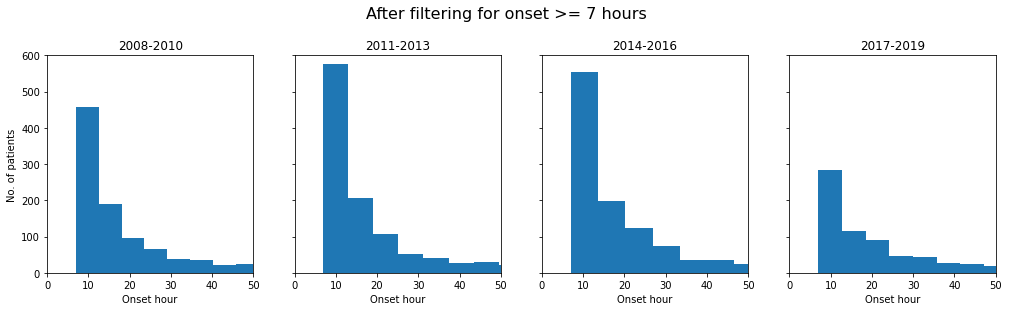

In [113]:
# filtered for early onset
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))
ef_agg = aggregated_df.loc[(aggregated_df['sepsis3_onset_hour'] > 6) | aggregated_df['sepsis3_onset_hour'].isna()]
ef_stat = static.loc[static.hadm_id.isin(ef_agg.hadm_id.unique())]
for group_i, year_group in enumerate(['2008-2010', '2011-2013', '2014-2016', '2017-2019']):
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    year_data = ef_agg.loc[(ef_agg['charttime'].dt.year>=start) & (ef_agg['charttime'].dt.year<=end)]
    static_data = ef_stat.loc[(ef_stat['intime'].dt.year>=start) & (ef_stat['intime'].dt.year<=end)]
    total = static.loc[(static['intime'].dt.year>=start) & (static['intime'].dt.year<=end)]
    print("Sepsis onset hour stats:")
    
    onset_hours = year_data.groupby('hadm_id')['sepsis3_onset_hour'].first()
   
    axs[group_i].hist(onset_hours, bins=30)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(0, 50)
    
    axs[group_i].set_xlabel('Onset hour')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of patients')
    
    print("Patients:", static_data.subject_id.nunique())
    print("Sepsis count:", static_data.loc[static_data['y']==True].shape[0])
    print("Percentage:", static_data.loc[static_data['y']==True].shape[0]/total.shape[0])
    
    print()
    
plt.ylim(0, 600)
plt.suptitle("After filtering for onset >= 7 hours", y=1.05, fontsize=16)
plt.show()

### filtered for early onset, no. of hours of data

Year group: 2008-2010
Avg. number of hours: 10.56959526159921

Year group: 2011-2013
Avg. number of hours: 10.05511811023622

Year group: 2014-2016
Avg. number of hours: 10.809853068280034

Year group: 2017-2019
Avg. number of hours: 12.628647214854112



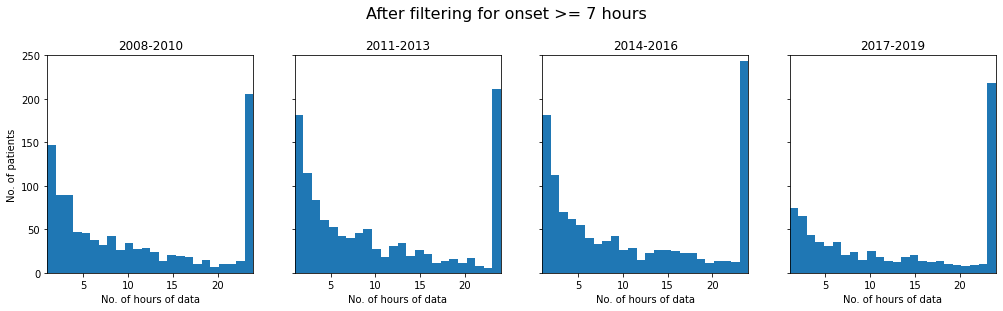

In [111]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))
ef_agg = aggregated_df.loc[aggregated_df['sepsis3_onset_hour'] > 6]
ef_stat = static.loc[static.hadm_id.isin(ef_agg.hadm_id.unique())]
for group_i, year_group in enumerate(['2008-2010', '2011-2013', '2014-2016', '2017-2019']):
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    year_data = ef_agg.loc[(ef_agg['charttime'].dt.year>=start) & (ef_agg['charttime'].dt.year<=end)]
    static_data = ef_stat.loc[(ef_stat['intime'].dt.year>=start) & (ef_stat['intime'].dt.year<=end)]
    total = static.loc[(static['intime'].dt.year>=start) & (static['intime'].dt.year<=end)]
    
    onset_hours = year_data.groupby('hadm_id')['sepsis3_onset_hour'].first()
    no_data_hours = np.clip(onset_hours - 6, 0, 24)
    
    axs[group_i].hist(no_data_hours, bins=24)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(1, 24)
    
    axs[group_i].set_xlabel('No. of hours of data')
    if group_i == 0:
        axs[group_i].set_ylabel('No. of patients')

    print("Avg. number of hours:", np.mean(no_data_hours))
    
    print()
    
plt.ylim(0, 250)
plt.suptitle("After filtering for onset >= 7 hours", y=1.05, fontsize=16)
plt.show()

### filtered for early onset, no. of hours of data (normalized within-year)

Year group: 2008-2010

Year group: 2011-2013

Year group: 2014-2016

Year group: 2017-2019



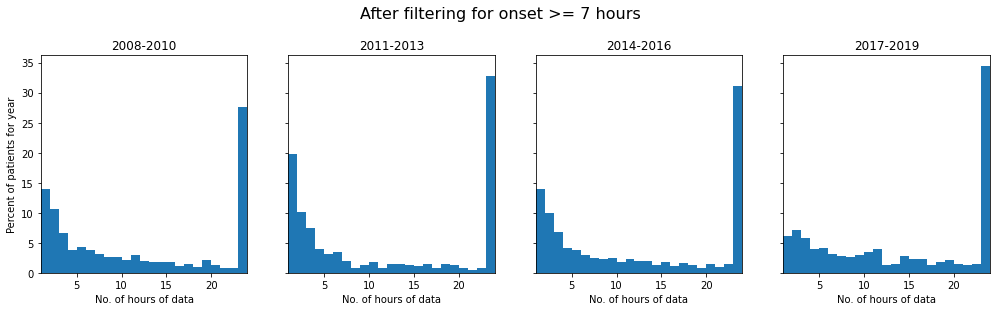

In [168]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 4))
ef_agg = aggregated_df.loc[aggregated_df['sepsis3_onset_hour'] > 6]
ef_stat = static.loc[static.hadm_id.isin(ef_agg.hadm_id.unique())]

for group_i, year_group in enumerate(['2008-2010', '2011-2013', '2014-2016', '2017-2019']):
    print("Year group:", year_group)
    
    start, end = map(int, year_group.split('-'))

    year_data = ef_agg.loc[(ef_agg['charttime'].dt.year>=start) & (ef_agg['charttime'].dt.year<=end)]
    static_data = ef_stat.loc[(ef_stat['intime'].dt.year>=start) & (ef_stat['intime'].dt.year<=end)]
    total = static.loc[(static['intime'].dt.year>=start) & (static['intime'].dt.year<=end)]
    #print("Sepsis onset hour stats:")
    
    onset_hours = year_data.groupby('hadm_id')['sepsis3_onset_hour'].mean()
    no_data_hours = np.clip(onset_hours - 6, 0, 24)
    #print(no_data_hours)
    #print(onset_hours)
    
    hist, bin_groups = np.histogram(no_data_hours, bins=23)
    hist = hist / np.sum(hist)
    
    axs[group_i].bar(bin_groups[:-1]+0.5, hist*100, width=1)

    axs[group_i].title.set_text(year_group)
    axs[group_i].set_xlim(1, 24)
    
    axs[group_i].set_xlabel('No. of hours of data')
    if group_i == 0:
        axs[group_i].set_ylabel('Percent of patients for year')
    
    print()
    
#plt.ylim(0, 375)
plt.suptitle("After filtering for onset >= 7 hours", y=1.05, fontsize=16)
plt.show()

In [17]:
data_cols = [col for col in static_12hr.columns if col not in ['subject_id', 'hadm_id', 'intime', 'y', 
                                                               'split_group']
                                                and not 'exist' in col and not 'time_since' in col]

In [18]:
last_hr_cols = ["('220045', 1.0)", "('220045', 12.0)", "('220045', 24.0)"]

In [29]:
for test_years in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    assign_splits(static, split_group='test', test_years=test_years)

    test_data = static[static.split_group == 'test']
    print("Years:", test_years)
    print("Sepsis3 percentage:", test_data.loc[test_data['y']==1].shape[0]/test_data.shape[0])
    print("HR stats", test_data["('220045', 1.0)"].describe())
    

Years: 2008-2010
Sepsis3 percentage: 0.13957597173144876
HR stats count    1132.000000
mean       80.479907
std        22.551698
min         0.000000
25%        70.000000
50%        81.000000
75%        94.000000
max       154.000000
Name: ('220045', 1.0), dtype: float64
Years: 2011-2013
Sepsis3 percentage: 0.11972295514511873
HR stats count    6064.000000
mean       79.880410
std        23.659058
min         0.000000
25%        69.000000
50%        81.000000
75%        94.000000
max       148.000000
Name: ('220045', 1.0), dtype: float64
Years: 2014-2016
Sepsis3 percentage: 0.13561553653719552
HR stats count    7595.000000
mean       80.331730
std        23.516533
min         0.000000
25%        69.000000
50%        81.000000
75%        94.000000
max       167.000000
Name: ('220045', 1.0), dtype: float64
Years: 2017-2019
Sepsis3 percentage: 0.13085983510011778
HR stats count    8490.000000
mean       80.554782
std        21.960718
min         0.000000
25%        70.000000
50%        80

In [28]:
test_data

,subject_id,hadm_id,intime,y,split_group,"('220045', 1.0)","('220045_exist', 1.0)","('220045_time_since', 1.0)"
22348,14059793,29348757,2008-06-29 15:53:00,False,test,96.000000,1,0.0
22366,14118396,21029585,2008-11-05 09:40:39,False,test,82.000000,1,0.0
22374,14133220,25200505,2008-08-09 13:04:48,False,test,62.000000,1,0.0
22380,14150131,26041899,2009-04-19 17:27:00,True,test,87.000000,1,0.0
22381,14150183,26500719,2008-04-15 01:18:00,True,test,99.666667,1,0.0
...,...,...,...,...,...,...,...,...
27828,19855190,24573952,2008-05-16 16:40:00,False,test,54.000000,1,0.0
27845,19901090,23248240,2010-03-13 19:38:38,False,test,104.000000,1,0.0
27863,19941204,22767931,2008-07-05 20:10:00,False,test,83.000000,1,0.0
27866,19950645,22775759,2008-11-01 00:22:29,False,test,87.000000,1,0.0


In [48]:
# Fishers r-to-z transformation to compute significance of difference between correlations
r_2011 = -0.21690583181608608
r_2017 = 0.08930221382818307

n_2011 = 6259
n_2017 = 8658

In [52]:
z_2011 = np.arctanh(r_2011)
z_2017 = np.arctanh(r_2017)

stderr = np.sqrt( (1/(n_2011-3)) + (1/(n_2017-3)) )

z = (z_2011 - z_2017)/stderr
z

-18.677417922122277

In [53]:
1 - scipy.stats.norm.cdf(abs(z))

0.0

## SI percent per year

In [26]:
for year_group in ['2008-2010', '2011-2013', '2014-2016', '2017-2019']:
    static_df_years = static_df.copy()

    assign_splits(static_df_years, split_group='test', test_years=year_group)
    aggregated_df_years = aggregated_df.merge(static_df_years[['hadm_id','split_group']], on='hadm_id')
    
    aggregated_df_years = aggregated_df_years.loc[aggregated_df_years.split_group == 'test']
    
    print("Year group:", year_group)
    #print(aggregated_df_years[['SOFA']].describe()) # TODO: extend with more columns
    #print(aggregated_df_years[['suspicion_of_infection']].value_counts())
    
    total = aggregated_df_years.shape[0]
    print("SI percentage:", aggregated_df_years.loc[aggregated_df_years['suspicion_of_infection']==True].shape[0]/total)
    print()

Year group: 2008-2010
SI percentage: 0.02292554994558527

Year group: 2011-2013
SI percentage: 0.02242981498365365

Year group: 2014-2016
SI percentage: 0.018609400883862228

Year group: 2017-2019
SI percentage: 0.013168003639656808



## Cohort selection numbers

In [71]:
min_patient_age = 15
min_hours=30
gap_hours=6
min_icu_stay=10
max_icu_stay=24

print("Filtering patient age...")
patients_filtered = patients.loc[patients["anchor_age"]>min_patient_age]
print("Total:", len(patients_filtered))

subject_ids = set(patients_filtered.subject_id.unique())
subject_ids = subject_ids.intersection(set(icustays.subject_id.unique()))
print("Total:", len(subject_ids))

print("Filtering hospital stay time...")
admissions_filtered = admissions.loc[admissions['dischtime']-admissions['admittime'] > pd.Timedelta(hours=min_hours+gap_hours)]

# update icustays to only include the patients that have been filtered in the previous steps
subject_ids = subject_ids.intersection(set(admissions_filtered['subject_id'].unique()))
icustays_filtered = icustays.loc[icustays["subject_id"].isin(subject_ids)]

print("Total:", len(subject_ids))


print("Filtering to first ICU stay...")
first_icustays = icustays_filtered.loc[icustays_filtered.groupby("subject_id")["intime"].idxmin()]
subject_ids = subject_ids.intersection(set(first_icustays.subject_id.unique()))
print("Total:", len(subject_ids))

print("Filtering ICU stay time...")
first_icustays = first_icustays.loc[first_icustays['outtime']-first_icustays['intime'] > pd.Timedelta(hours=min_icu_stay)]
first_icustays = first_icustays.loc[first_icustays['outtime']-first_icustays['intime'] < pd.Timedelta(days=max_icu_stay)]

hadm_ids = set(first_icustays.hadm_id).intersection(set(admissions.hadm_id))
first_icustays = first_icustays.loc[first_icustays.hadm_id.isin(hadm_ids)]

subject_ids = subject_ids.intersection(set(first_icustays.subject_id.unique()))
print("Total:", len(subject_ids))

admissionspatients_filtered = admissions.loc[admissions.subject_id.isin(subject_ids)]
patients_filtered = patients.loc[patients.subject_id.isin(subject_ids)]

print(len(patients_filtered))


Filtering patient age...
Total: 321406
Total: 53150
Filtering hospital stay time...
Total: 51097
Filtering to first ICU stay...
Total: 51097
Filtering ICU stay time...
Total: 49618
49618


## ER / transfer / mortality analysis

In [10]:
%%time
transfers = pd.read_csv("../mimiciv/1.0/core/transfers.csv.gz")
transfers['intime'] = pd.to_datetime(transfers['intime'])
transfers['outtime'] = pd.to_datetime(transfers['outtime'])
transfers = anchor_dates(transfers, ['intime', 'outtime'], patients)

CPU times: user 5.9 s, sys: 427 ms, total: 6.33 s
Wall time: 6.28 s


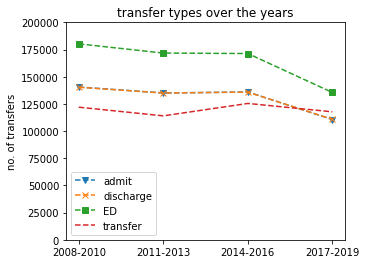

In [11]:
markers = {
    'admit': 'v',
    'discharge': 'x',
    'ED': 's',
    'transfer': '',
}

plt.figure(figsize=(5,4))

for i, etype in enumerate(transfers.eventtype.unique()):
    df = transfers.loc[transfers.eventtype == etype]
    
    counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(df, start_year, end_year, filter_on='intime'))
        counts.append(count)
    
    plt.plot(YEAR_GROUPS, counts, label=etype, linestyle='--', marker=markers[etype])
    
plt.ylabel('no. of transfers')
plt.title("transfer types over the years")
plt.ylim(0, 200000)
plt.legend()

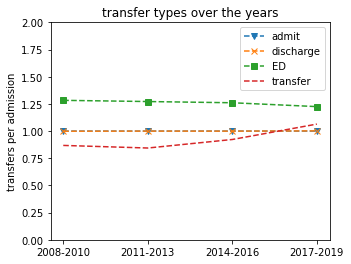

In [14]:
markers = {
    'admit': 'v',
    'discharge': 'x',
    'ED': 's',
    'transfer': '',
}

plt.figure(figsize=(5,4))

for i, etype in enumerate(transfers.eventtype.unique()):
    df = transfers.loc[transfers.eventtype == etype]
    
    counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        
        admit_count = len(filter_to_year_group(admissions, start_year, end_year, filter_on='admittime'))
        
        count = len(filter_to_year_group(df, start_year, end_year, filter_on='intime'))
        count = count/admit_count
        counts.append(count)

    plt.plot(YEAR_GROUPS, counts, label=etype, linestyle='--', marker=markers[etype])
    
plt.ylabel('transfers per admission')
plt.title("transfer types over the years")
plt.ylim(0, 2)
plt.legend()

Text(0.5, 1.0, 'Hospital admissions')

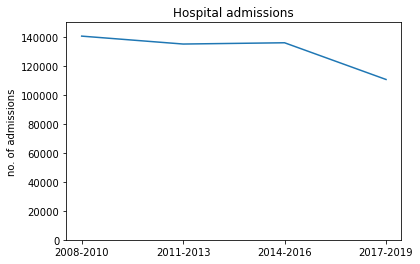

In [165]:
counts = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    count = len(filter_to_year_group(admissions, start_year, end_year, filter_on='admittime'))
    counts.append(count)

plt.plot(YEAR_GROUPS, counts)
plt.ylabel("no. of admissions")
plt.ylim(0,150000)
plt.title("Hospital admissions")

[76681, 76917, 79341, 72067]


Text(0.5, 1.0, 'No. of unique patients admitted to hospital')

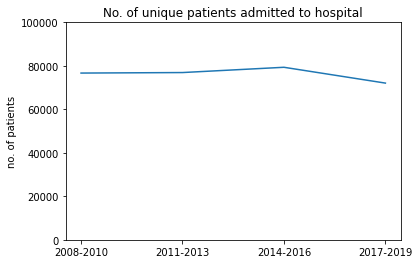

In [16]:
counts = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    count = filter_to_year_group(admissions, start_year, end_year, filter_on='admittime').subject_id.nunique()
    counts.append(count)

print(counts)
plt.plot(YEAR_GROUPS, counts)
plt.ylabel("no. of patients")
plt.ylim(0,100000)
plt.title("No. of unique patients admitted to hospital")

In [173]:
icustays.merge(transfers.loc[transfers.eventtype == 'transfer'], on='hadm_id')

,subject_id_x,hadm_id,stay_id,first_careunit,last_careunit,intime_x,outtime_x,los,subject_id_y,transfer_id,eventtype,careunit,intime_y,outtime_y
0,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2018-06-19 17:57:00,2018-06-22 18:33:54,3.025625,14435996,34787286,transfer,Medicine,2018-06-22 18:33:54,2018-06-25 15:36:45
1,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2008-10-24 10:35:00,2008-10-24 18:59:47,0.350544,18966770,32176518,transfer,Trauma SICU (TSICU),2008-10-24 10:49:22,2008-10-24 18:59:47
2,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2008-10-24 10:35:00,2008-10-24 18:59:47,0.350544,18966770,33060653,transfer,Surgery/Trauma,2008-10-24 18:59:47,2008-10-25 11:26:33
3,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2016-07-11 00:33:00,2016-07-12 16:44:40,1.674769,12776735,37795407,transfer,Neurology,2016-07-12 16:44:40,2016-07-13 14:57:32
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2016-07-11 00:33:00,2016-07-12 16:44:40,1.674769,12776735,30204446,transfer,Neurology,2016-07-13 14:57:32,2016-07-18 12:08:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216336,12275003,22562812,39992247,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2014-08-15 09:37:33,2014-08-16 17:25:44,1.325127,12275003,36722503,transfer,Cardiac Surgery,2014-08-16 17:25:44,2014-08-19 18:03:20
216337,17840864,22695803,39999810,Neuro Intermediate,Neuro Intermediate,2017-12-01 00:37:00,2017-12-05 18:27:57,4.743715,17840864,34987260,transfer,Neuro Intermediate,2017-12-01 01:10:56,2017-12-01 02:11:47
216338,17840864,22695803,39999810,Neuro Intermediate,Neuro Intermediate,2017-12-01 00:37:00,2017-12-05 18:27:57,4.743715,17840864,30444113,transfer,Neuro Intermediate,2017-12-01 02:11:47,2017-12-04 13:09:05
216339,17840864,22695803,39999810,Neuro Intermediate,Neuro Intermediate,2017-12-01 00:37:00,2017-12-05 18:27:57,4.743715,17840864,33612485,transfer,Neuro Intermediate,2017-12-04 13:09:05,2017-12-05 18:27:57


## comparing patient's treatment locations:

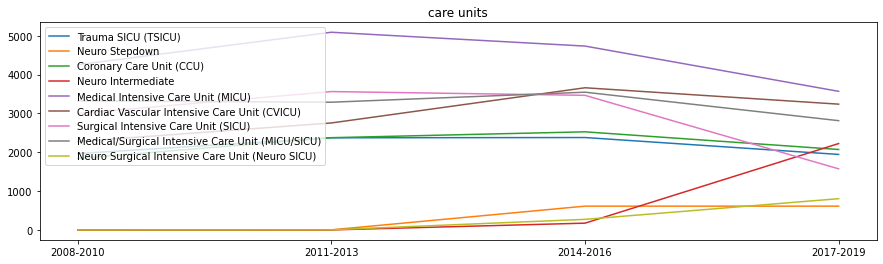

In [179]:
# icustays.last_careunit
plt.figure(figsize=(15,4))

for i, etype in enumerate(icustays.last_careunit.unique()):
    df = icustays.loc[icustays.last_careunit == etype]
    
    counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(df, start_year, end_year, filter_on='intime'))
        counts.append(count)
    
    plt.plot(YEAR_GROUPS, counts, label=etype)
    
plt.title("care units")
plt.legend()

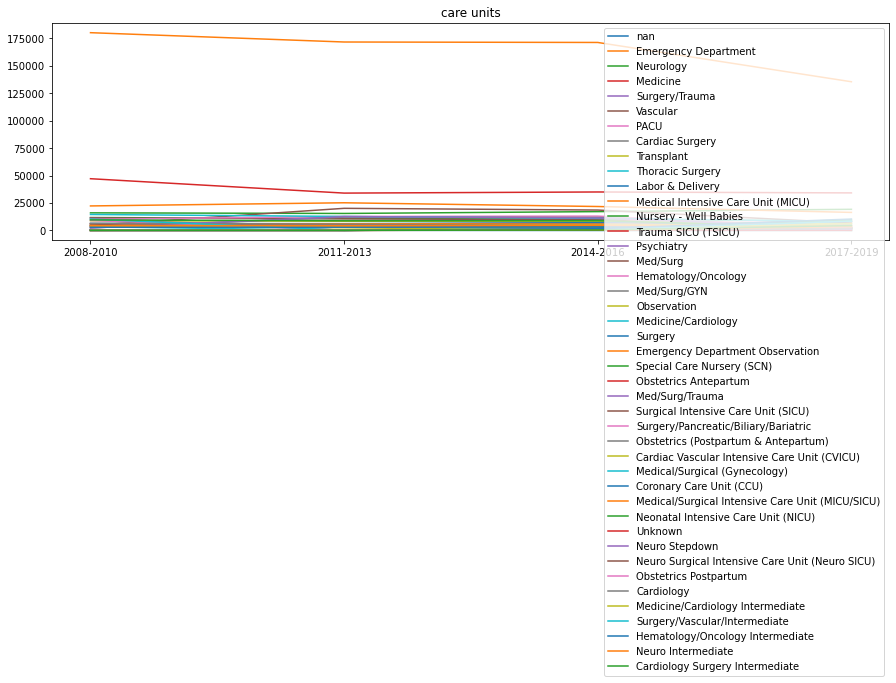

In [180]:
# transfers.careunit
plt.figure(figsize=(15,4))

for i, etype in enumerate(transfers.careunit.unique()):
    df = transfers.loc[transfers.careunit == etype]
    
    counts = []
    for year_group in YEAR_GROUPS:
        start_year, end_year = map(int, year_group.split('-'))
        count = len(filter_to_year_group(df, start_year, end_year, filter_on='intime'))
        counts.append(count)
    
    plt.plot(YEAR_GROUPS, counts, label=etype)
    
plt.title("care units")
plt.legend()

### Compare mortality rates of different careunits per year (TODO)

In [ ]:
## TODO:

Transfer history per patient:

In [11]:
#.merge(icustays[['subject_id', 'hadm_id','stay_id','los']], on=['subject_id', 'hadm_id'], how='left')\
main_df = transfers\
        .sort_values(by=['subject_id','intime'])
main_df.loc[main_df.hadm_id.isna(), 'hadm_id'] = -1
main_df = main_df.groupby(['subject_id','hadm_id'])
for i in tqdm(range(25)):
    nth_transfer = main_df.nth(i)
    
    if len(nth_transfer) == 0:
        break
    
    if i == 0:
        df = pd.DataFrame({'history': nth_transfer.eventtype}, index=nth_transfer.index)
    else:
        df.loc[nth_transfer.index, 'history'] += ','
        df.loc[nth_transfer.index, 'history'] += nth_transfer.eventtype

df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.11s/it]


history
subject_id hadm_id                                                
10000019    25058216.0  admit,transfer,transfer,transfer,discharge
10000032    22595853.0                          ED,admit,discharge
            22841357.0                          ED,admit,discharge
            25742920.0                          ED,admit,discharge
            29079034.0     ED,ED,admit,transfer,transfer,discharge
...                                                            ...
19999829   -1.0                                                 ED
19999840    21033226.0        ED,admit,transfer,transfer,discharge
            26071774.0                          ED,admit,discharge
19999914   -1.0                                                 ED
19999987    23865745.0                 ED,admit,transfer,discharge

[715960 rows x 1 columns]

In [ ]:
# counts for top-10 histories:
df.value_counts().iloc[:10]

In [12]:
# evolution of histories over the years
result = dict((g, {}) for g in YEAR_GROUPS)
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    
    main_df = filter_to_year_group(transfers, start_year, end_year, filter_on='intime')
    main_df = main_df.sort_values(by=['subject_id','intime'])
    
    main_df.loc[main_df.hadm_id.isna(), 'hadm_id'] = -1
    main_df = main_df.groupby(['subject_id','hadm_id'])
    for i in tqdm(range(5)):
        nth_transfer = main_df.nth(i)

        if len(nth_transfer) == 0:
            break

        if i == 0:
            df = pd.DataFrame({'history': nth_transfer.eventtype}, index=nth_transfer.index)
        else:
            df.loc[nth_transfer.index, 'history'] += ','
            df.loc[nth_transfer.index, 'history'] += nth_transfer.eventtype

    value_counts = df.value_counts()
    for key in value_counts.index:
        result[year_group][key[0]] = value_counts.loc[key]

result = pd.DataFrame(result)
result.iloc[:25]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


,2008-2010,2011-2013,2014-2016,2017-2019
"ED,admit,discharge",49911.0,50016.0,48061.0,35402.0
ED,43969.0,43867.0,45322.0,42152.0
"admit,discharge",24249.0,23720.0,22691.0,17695.0
"admit,transfer,discharge",18510.0,16590.0,17302.0,14684.0
"ED,admit,transfer,discharge",17365.0,16115.0,16176.0,13137.0
"ED,ED",10122.0,9301.0,8960.0,6548.0
"admit,transfer,transfer,discharge",8433.0,7645.0,8240.0,7427.0
"ED,admit,transfer,transfer,discharge",8146.0,7808.0,8342.0,7313.0
"ED,admit,transfer,transfer,transfer",7305.0,7257.0,8378.0,8170.0
"ED,ED,ED",3573.0,3027.0,3012.0,1892.0


In [ ]:
adm_yrs = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    adm_yr = len(filter_to_year_group(admissions, start_year, end_year, filter_on='admittime'))
    adm_yrs.append(adm_yrs)

result_percent = result/np.array(adm_yrs) * 100
result_percent.iloc[:5]

In [ ]:
data = result_percent.iloc[:9].melt(value_vars=['2008-2010','2011-2013','2014-2016','2017-2019'], 
                                    ignore_index=False, var_name='year_group', 
                                    value_name='percent of admissions').reset_index()
data.dropna(inplace=True)

g = sns.FacetGrid(data, col='index', col_wrap=3)
g.map(sns.lineplot, "year_group", "patients")

### mortality rates for patients with/without ICU stays

,year_group,no. of patients,% of patients
0,2008-2010,2919,2.460882
1,2011-2013,1867,2.022379
2,2014-2016,1735,1.960718
3,2017-2019,1397,1.686037


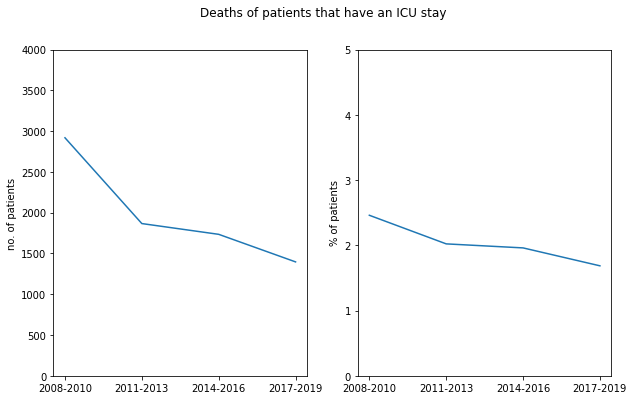

In [17]:
sids = icustays.subject_id.unique()

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    
    patients_icu_yr = patients_yr.loc[patients_yr.subject_id.isin(sids)]
    
    mort_count = len(patients_icu_yr.dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
axs[0].set_ylim(0,4000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
axs[1].set_ylim(0,5)
#plt.ylim(0,6000)
plt.suptitle("Deaths of patients that have an ICU stay")

pd.DataFrame({'year_group': YEAR_GROUPS, 'no. of patients': counts, '% of patients': percents})

,year_group,no. of patients,% of patients
0,2008-2010,799,0.673602
1,2011-2013,293,0.317385
2,2014-2016,259,0.292695
3,2017-2019,240,0.289656


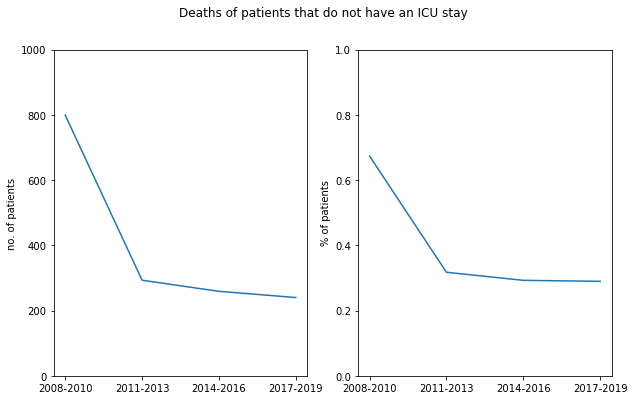

In [633]:
sids = icustays.subject_id.unique()

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    
    mort_count = len(patients_yr.loc[~patients_yr.subject_id.isin(sids)].dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
axs[0].set_ylim(0,1000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
axs[1].set_ylim(0,1)
#plt.ylim(0,6000)
plt.suptitle("Deaths of patients that do not have an ICU stay")

pd.DataFrame({'year_group': YEAR_GROUPS, 'no. of patients': counts, '% of patients': percents})

### mortality rates for patients with/without 'transfer's

[3110, 1700, 1503, 1206]
[2.621905982329534, 1.84148098400078, 1.6985353946297803, 1.4555197508961222]


,year_group,no. of patients,% of patients
0,2008-2010,3110,2.621906
1,2011-2013,1700,1.841481
2,2014-2016,1503,1.698535
3,2017-2019,1206,1.455520


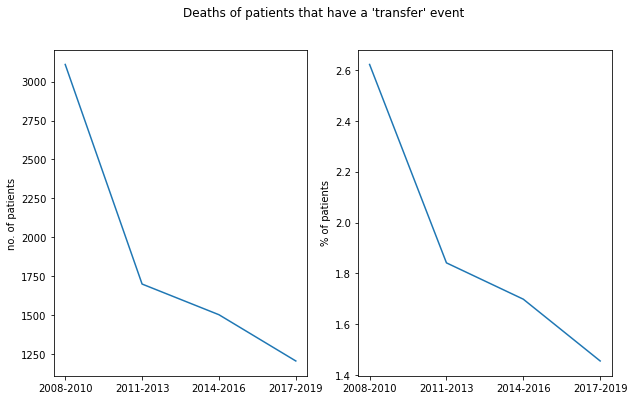

In [634]:
df = transfers.loc[transfers.eventtype == 'transfer']
transfer_sids = df.subject_id.unique()

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    patients_transfer_yr = patients_yr.loc[patients_yr.subject_id.isin(transfer_sids)]
    
    mort_count = len(patients_transfer_yr.dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
print(counts)
print(percents)
    
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
#axs[0].set_ylim(0,4000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
#axs[1].set_ylim(0,5)
plt.suptitle("Deaths of patients that have a 'transfer' event")

pd.DataFrame({'year_group': YEAR_GROUPS, 'no. of patients': counts, '% of patients': percents})

[608, 460, 491, 431]
[0.5125784042624941, 0.4982830897884464, 0.5548774975137871, 0.520173310643639]


,year_group,no. of patients,% of patients
0,2008-2010,608,0.512578
1,2011-2013,460,0.498283
2,2014-2016,491,0.554877
3,2017-2019,431,0.520173


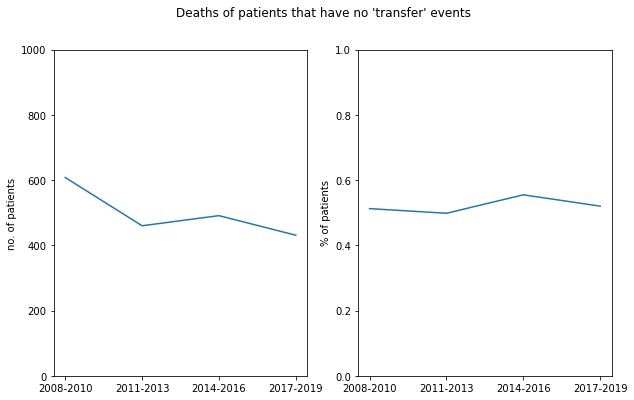

In [635]:
df = transfers.loc[transfers.eventtype == 'transfer']
transfer_sids = df.subject_id.unique()

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    
    mort_count = len(patients_yr.loc[~patients_yr.subject_id.isin(transfer_sids)].dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
print(counts)
print(percents)
    
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
axs[0].set_ylim(0,1000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
axs[1].set_ylim(0,1)
#plt.ylim(0,6000)
plt.suptitle("Deaths of patients that have no 'transfer' events")

pd.DataFrame({'year_group': YEAR_GROUPS, 'no. of patients': counts, '% of patients': percents})

Text(0.5, 0.98, "Deaths of ICU patients that have a 'transfer' event")

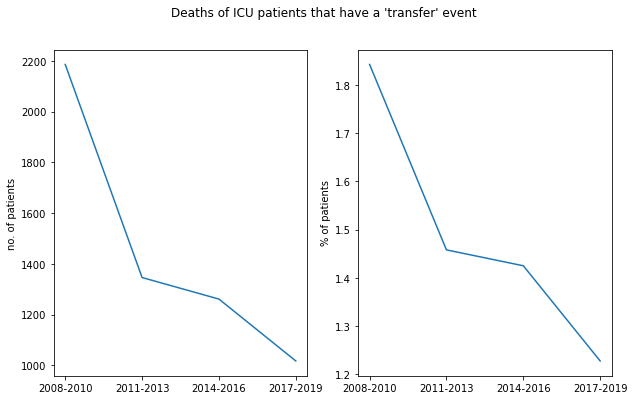

In [645]:
df = transfers.loc[transfers.eventtype == 'transfer']
df = df.loc[df.subject_id.isin(icustays.subject_id.unique())]

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(df, start_year, end_year, filter_on='intime')
    
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    
    patients_etype_yr = patients_yr.loc[patients_yr.subject_id.isin(df_yr.subject_id.unique())]
    #admissions_etype_yr = patients_yr[['subject_id', 'dod']].merge(df_yr, on='subject_id', how='left')
    
    #print(admissions_etype_yr)
    
    mort_count = len(patients_etype_yr.dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
#axs[0].set_ylim(0,6000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
#axs[1].set_ylim(0,5)
#plt.ylim(0,6000)
plt.suptitle("Deaths of ICU patients that have a 'transfer' event")

### Trying another method of filtering for ICU units:

Text(0.5, 0.98, 'Deaths of ICU patients (ICU filtered by careunit description)')

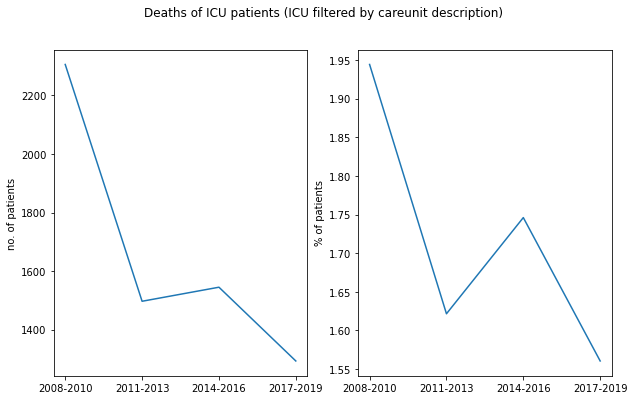

In [651]:
ICU_UNITS = [
    'Medical Intensive Care Unit (MICU)',
    'Trauma SICU (TSICU)',
    'Surgical Intensive Care Unit (SICU)',
    'Cardiac Vascular Intensive Care Unit (CVICU)',
    'Medical/Surgical Intensive Care Unit (MICU/SICU)',
    'Neonatal Intensive Care Unit (NICU)',
    'Neuro Surgical Intensive Care Unit (Neuro SICU)',
    #'Coronary Care Unit (CCU)'
]

df = transfers.loc[transfers.careunit.isin(ICU_UNITS)]

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(df, start_year, end_year, filter_on='intime')
    
    patients_yr = filter_to_year_group(patients, start_year, end_year, filter_on='anchor_year_group')
    
    patients_etype_yr = patients_yr.loc[patients_yr.subject_id.isin(df_yr.subject_id.unique())]
    #admissions_etype_yr = patients_yr[['subject_id', 'dod']].merge(df_yr, on='subject_id', how='left')
    
    #print(admissions_etype_yr)
    
    mort_count = len(patients_etype_yr.dod.dropna())
    mort_percent = (mort_count / len(patients_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

axs[0].plot(YEAR_GROUPS, counts)
axs[0].set_ylabel("no. of patients")
#axs[0].set_ylim(0,6000)

axs[1].plot(YEAR_GROUPS, percents)
axs[1].set_ylabel("% of patients")
#axs[1].set_ylim(0,5)
#plt.ylim(0,6000)
plt.suptitle("Deaths of ICU patients (ICU filtered by careunit description)")

### Overall In-ICU mortality

In [624]:
static_df = icustays.merge(admissions[['hadm_id','deathtime']], on='hadm_id', how='inner')
static_df['death_in_icu'] = (~static_df['deathtime'].isna()) & (static_df['deathtime'] >= static_df['intime']) & \
                                    (static_df['deathtime'] <= static_df['outtime'])

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(static_df, start_year, end_year, filter_on='intime')
    
    mort_count = df_yr.death_in_icu.sum()
    mort_percent = (mort_count / df_yr.subject_id.nunique()) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
counts, percents

([1177, 1385, 1574, 1473],
 [9.728076700553764, 9.71043959896235, 9.830127404446664, 10.224196571111266])

### Overall mortality rates for patients in our cohort with/without an ICU stay

In [354]:
counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(static_df, start_year, end_year, filter_on='intime')
    
    mort_count = len(df_yr.deathtime.dropna())
    mort_percent = (mort_count / len(df_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
counts, percents

([669, 738, 932, 822],
 [8.062183658712943, 7.869481765834934, 8.753639522870293, 8.64353312302839])

### Overall mortality rates for patients in our cohort

In [614]:
static_df = static.merge(admissions[['hadm_id', 'deathtime']], on='hadm_id', how='left')

counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(static_df, start_year, end_year, filter_on='intime')
    
    mort_count = len(df_yr.deathtime.dropna())
    mort_percent = (mort_count / len(df_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)
    
counts, percents

([669, 738, 932, 822],
 [8.062183658712943, 7.869481765834934, 8.753639522870293, 8.64353312302839])

### Overall In-ICU Mortality rates for our cohort

In [615]:
#static_df = icustays.merge(admissions[['hadm_id','deathtime']], on='hadm_id', how='inner')
static_df = static.merge(admissions[['hadm_id', 'deathtime']], on='hadm_id', how='left')
static_df['death_in_icu'] = (~static_df['deathtime'].isna()) & (static_df['deathtime'] >= static_df['intime']) & \
                                    (static_df['deathtime'] <= static_df['outtime'])


In [616]:
counts = []
percents = []
for year_group in YEAR_GROUPS:
    start_year, end_year = map(int, year_group.split('-'))
    df_yr = filter_to_year_group(static_df, start_year, end_year, filter_on='intime')
    
    mort_count = df_yr.death_in_icu.sum()
    mort_percent = (mort_count / len(df_yr)) * 100
    
    counts.append(mort_count)
    percents.append(mort_percent)

counts, percents

([395, 433, 542, 498],
 [4.760183176669077, 4.617189166133504, 5.090635859866629, 5.236593059936909])